<a href="https://colab.research.google.com/github/Vikramkotlo/apriori/blob/main/harshini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col
import matplotlib.pyplot as plt

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("DatasetAnalysis").getOrCreate()

In [ ]:
from pyspark.sql.functions import count, when, avg, col
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType

In [ ]:
# Load the dataset from a CSV file
df = spark.read.format("csv").option("header", "true").load("/content/sample_data/Acid_quality_dataset.csv")


In [ ]:
# Print the first 5 rows of the dataset to check if it has been loaded correctly
df.show(5)

+----------------------+-----------------+--------------+------------+------------------+--------------------------+-------------+
|Acid Concentration (%)|Temperature (Â°C)|Pressure (psi)|Type of Acid|Production Process|Time Since Produced (days)|Quality Score|
+----------------------+-----------------+--------------+------------+------------------+--------------------------+-------------+
|                  36.7|               28|          14.2|           0|                 2|                         9|            6|
|                  91.5|               51|           9.8|           3|                 1|                        21|            8|
|                    70|               40|            25|           1|                 6|                        10|            8|
|                  77.8|               42|          11.3|           1|                 6|                        28|            8|
|                    72|               51|            30|           1|             

In [ ]:
df.printSchema()

root
 |-- Acid Concentration (%): string (nullable = true)
 |-- Temperature (Â°C): string (nullable = true)
 |-- Pressure (psi): string (nullable = true)
 |-- Type of Acid: string (nullable = true)
 |-- Production Process: string (nullable = true)
 |-- Time Since Produced (days): string (nullable = true)
 |-- Quality Score: string (nullable = true)



In [ ]:
new_schema = StructType([
StructField('Acid Concentration (%)', DoubleType(), True),
StructField('Temperature (°C)', IntegerType(), True),
StructField('Pressure (psi)', DoubleType(), True),
StructField('Type of Acid', IntegerType(), True),
StructField('Production Process', IntegerType(), True),
StructField('Time Since Produced (days)', IntegerType(), True),
StructField('Quality Score', DoubleType(), True)
])
df = df.select([col(c).cast(new_schema.fields[i].dataType) for i, c in enumerate(df.columns)])

In [ ]:
# Verify the new data types of the columns
df.printSchema()

root
 |-- Acid Concentration (%): double (nullable = true)
 |-- Temperature (Â°C): integer (nullable = true)
 |-- Pressure (psi): double (nullable = true)
 |-- Type of Acid: integer (nullable = true)
 |-- Production Process: integer (nullable = true)
 |-- Time Since Produced (days): integer (nullable = true)
 |-- Quality Score: double (nullable = true)



In [ ]:
# Calculate basic statistics for each numerical column
df.describe().show()

+-------+----------------------+------------------+-----------------+-----------------+------------------+--------------------------+-----------------+
|summary|Acid Concentration (%)| Temperature (Â°C)|   Pressure (psi)|     Type of Acid|Production Process|Time Since Produced (days)|    Quality Score|
+-------+----------------------+------------------+-----------------+-----------------+------------------+--------------------------+-----------------+
|  count|                   250|               250|              250|              250|               250|                       250|              250|
|   mean|    57.428399999999996|            57.556|           15.868|            1.312|             3.668|                    15.748|              7.0|
| stddev|    27.827471067707474|21.870164158535367|9.728759997262616|1.238057813106633| 2.382536868069588|         7.606043887229273|1.417050503162839|
|    min|                  20.7|                20|              5.0|                0| 

In [ ]:
# Check for any missing values in the dataset
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------------------+-----------------+--------------+------------+------------------+--------------------------+-------------+
|Acid Concentration (%)|Temperature (Â°C)|Pressure (psi)|Type of Acid|Production Process|Time Since Produced (days)|Quality Score|
+----------------------+-----------------+--------------+------------+------------------+--------------------------+-------------+
|                     0|                0|             0|           0|                 0|                         0|            0|
+----------------------+-----------------+--------------+------------+------------------+--------------------------+-------------+



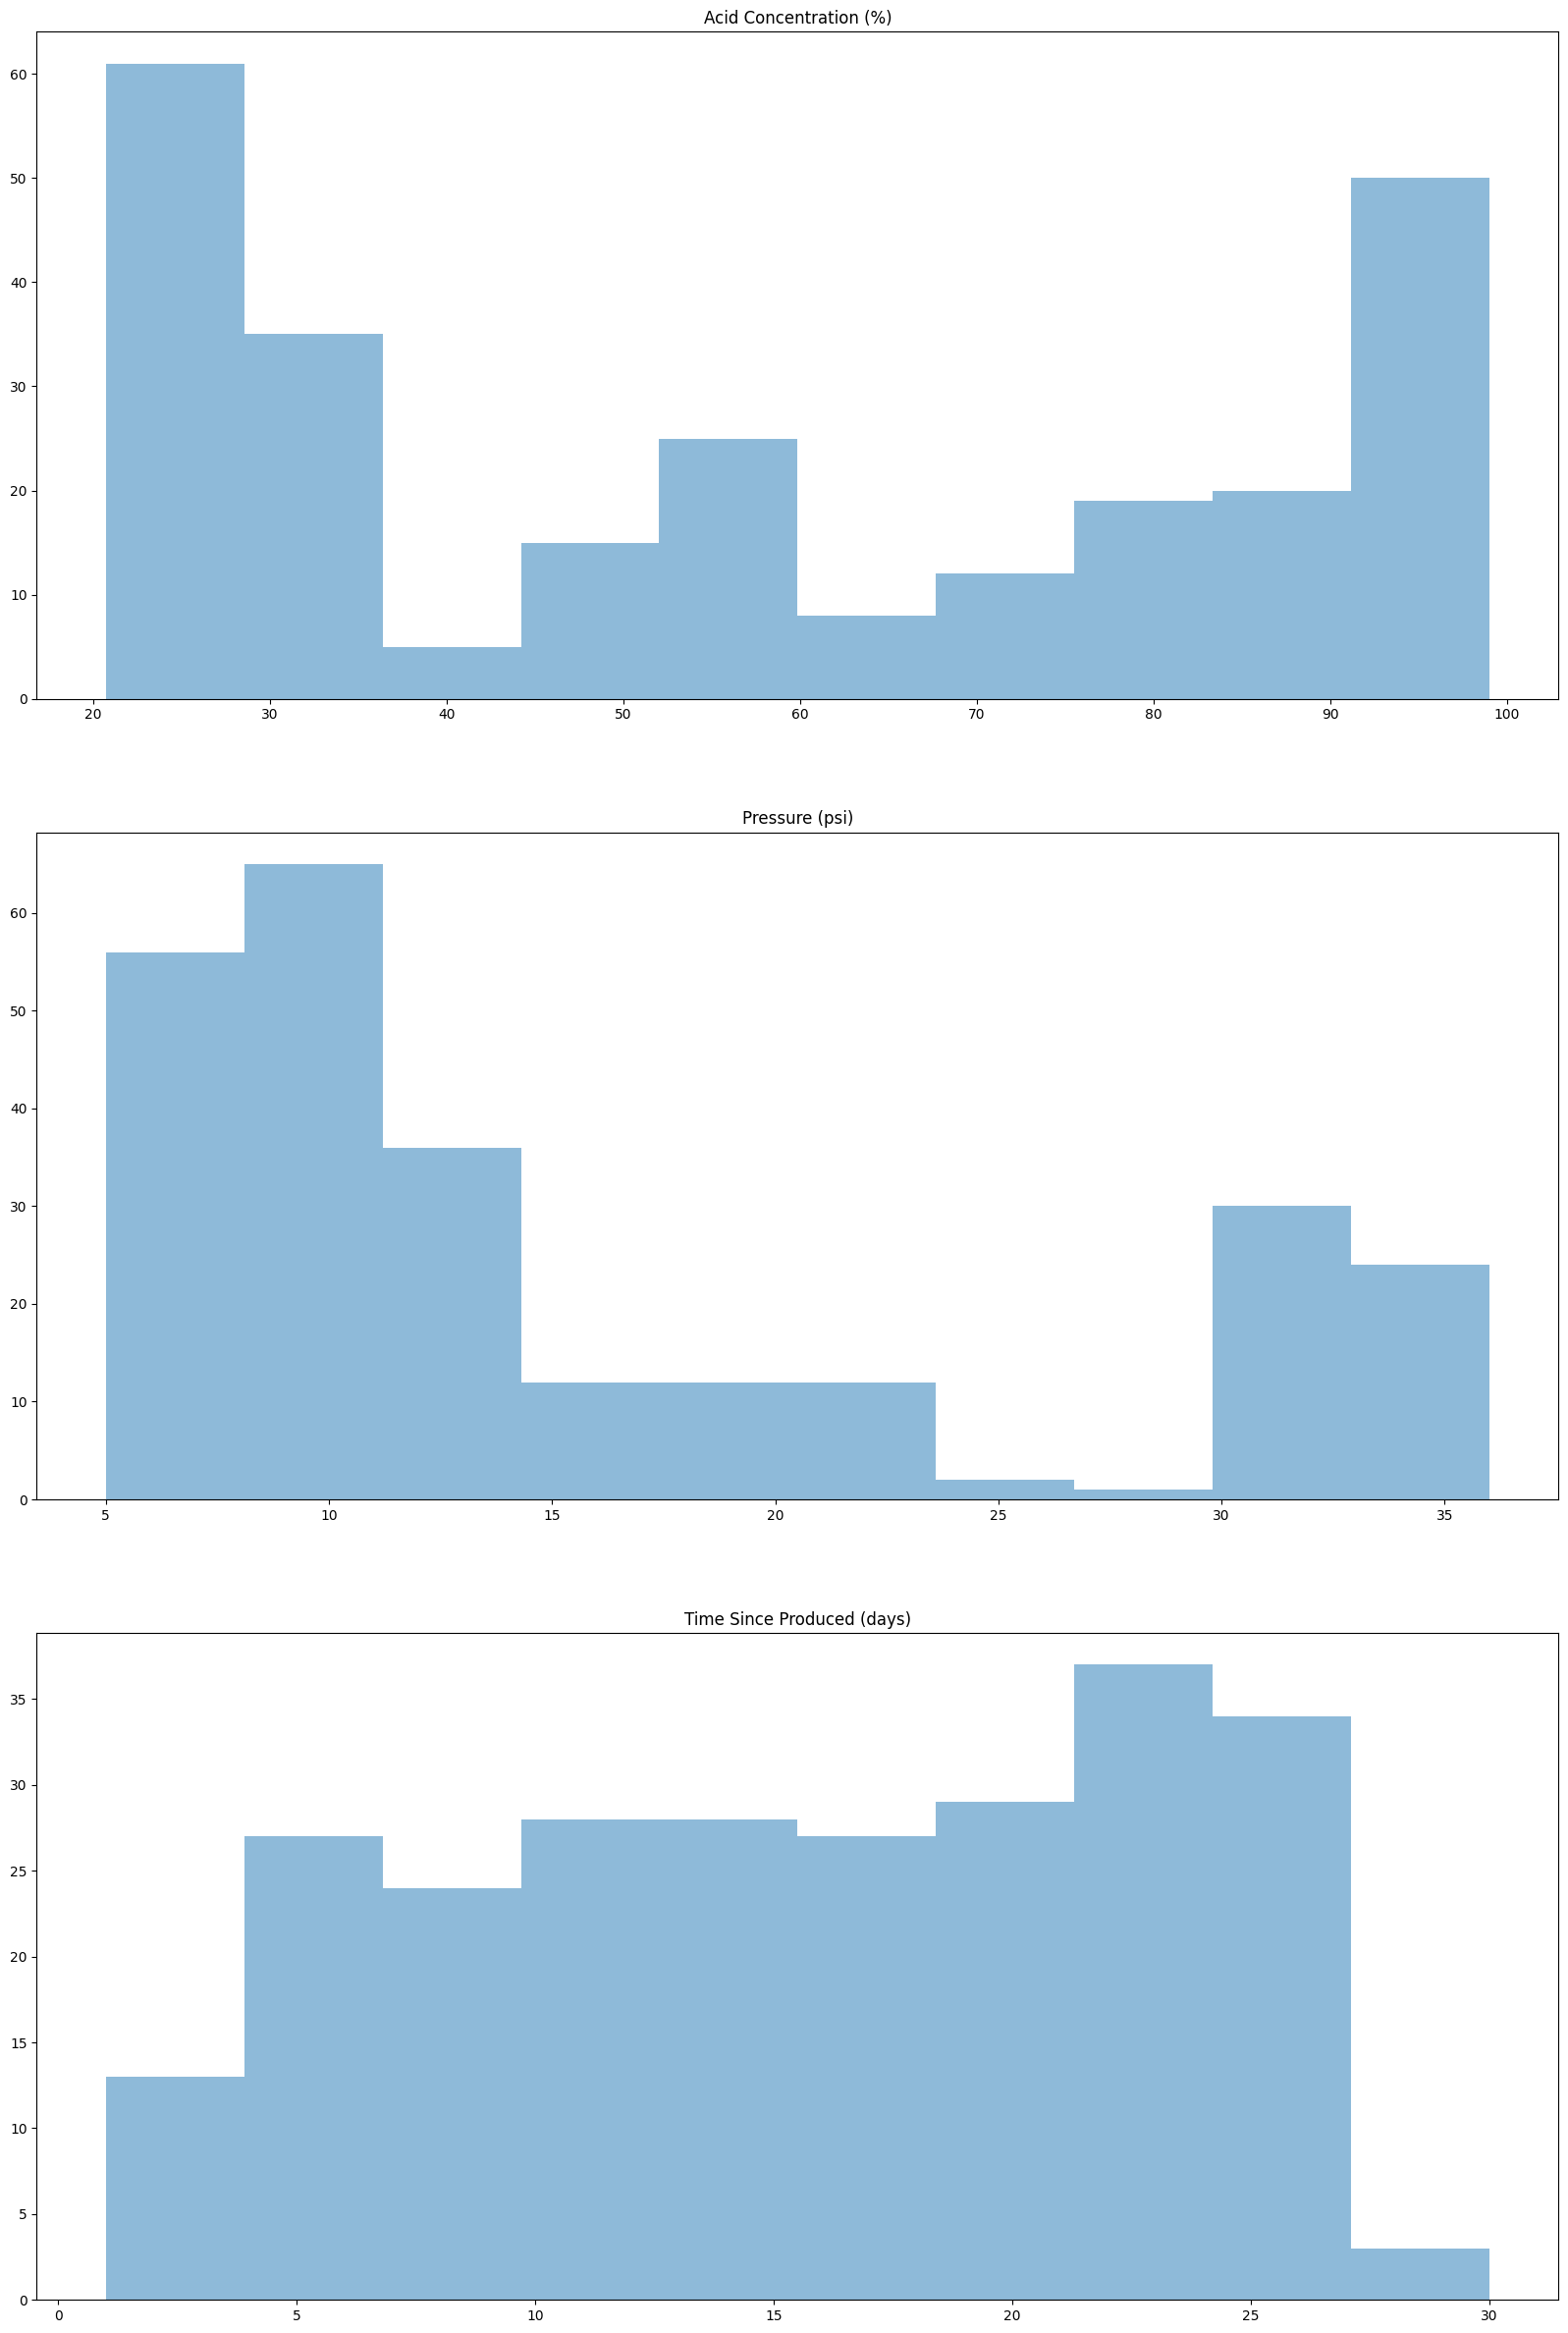

In [ ]:
num_cols = ['Acid Concentration (%)', 'Pressure (psi)', 'Time Since Produced (days)']
fig, axs = plt.subplots(nrows=len(num_cols), figsize=(20, 30))
for i, col in enumerate(num_cols):
    # Get the range of values for the current column
    min_val, max_val = df.agg({"{}".format(col): "min"}).collect()[0][0], df.agg({"{}".format(col): "max"}).collect()[0][0]
    # Create a histogram with a range of values and sorted data
    axs[i].hist(df.select(col).rdd.flatMap(lambda x: x).collect(), range=(min_val, max_val), bins=10, alpha=0.5)
    axs[i].set_title(col)
plt.show()

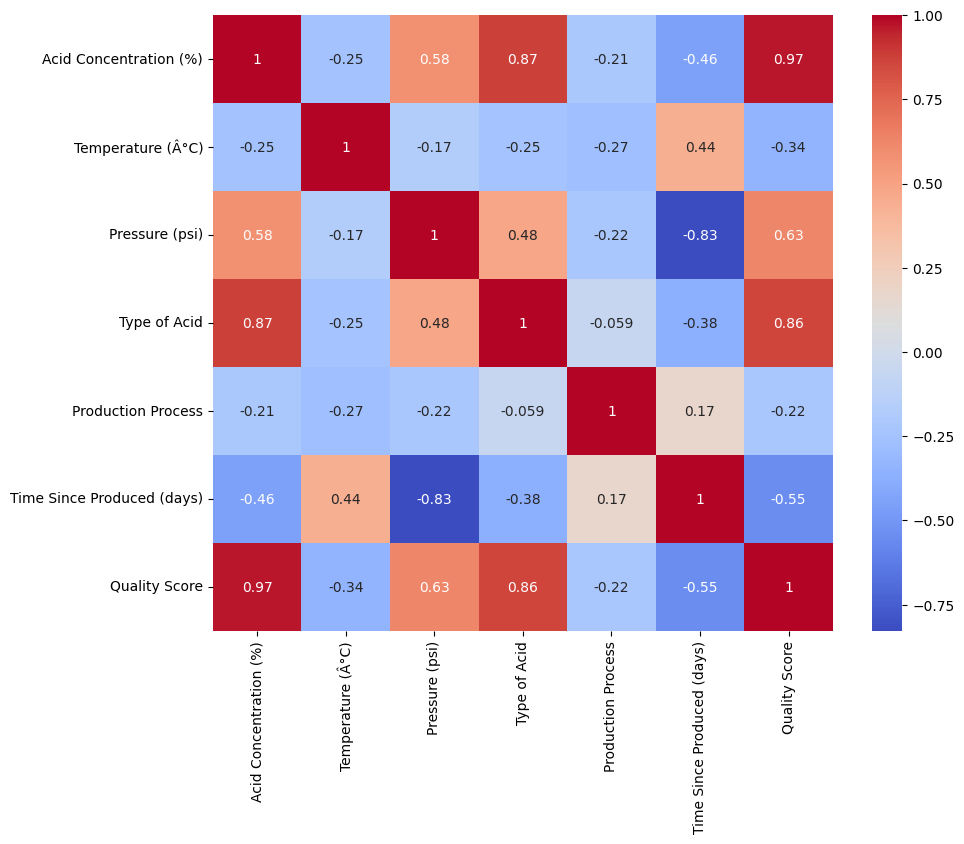

In [ ]:
# Visualize the correlation between columns using a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df.toPandas().corr(), annot=True, cmap="coolwarm")
plt.show()

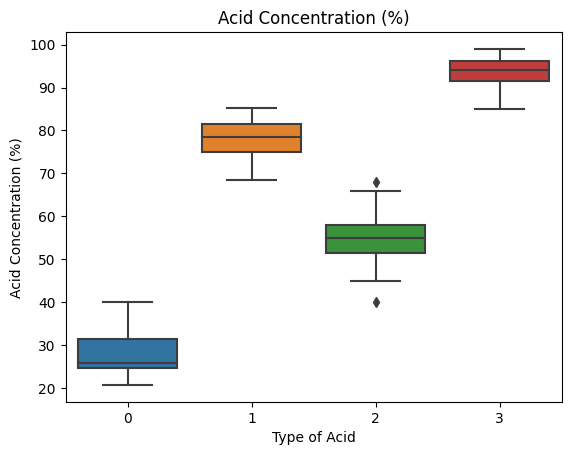

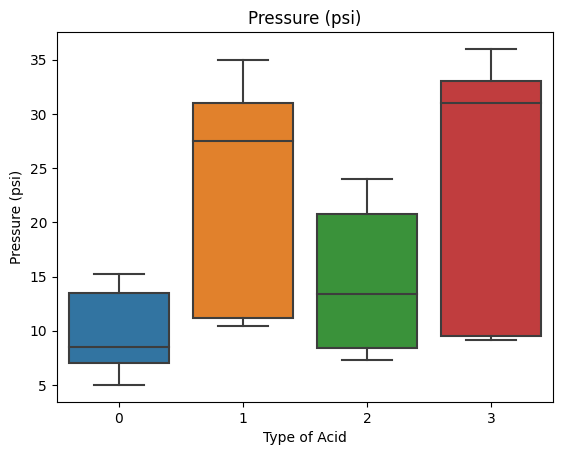

In [ ]:
# Boxplots of numerical variables by acid type
# Define the list of numerical columns
num_cols = ['Acid Concentration (%)', 'Pressure (psi)']
# Create a boxplot for each numerical column grouped by acid type
for col in num_cols:
    sns.boxplot(x='Type of Acid', y=col, data=df.toPandas())
    plt.title(col)
    plt.show()

In [ ]:
acid_scores = df.groupby('Type of Acid').agg(avg('Quality Score').alias('Mean Quality Score'))
sorted_acid_scores = acid_scores.sort('Type of Acid', ascending=True)

In [ ]:
# Show the results
sorted_acid_scores.show()

+------------+------------------+
|Type of Acid|Mean Quality Score|
+------------+------------------+
|           0|               5.5|
|           1| 8.027777777777779|
|           2|               7.0|
|           3|          8.765625|
+------------+------------------+



In [ ]:
# Group the dataset by the 'Time Since Produced' column and calculate the mean quality score for each time period
time_scores = df.groupby('Time Since Produced (days)').agg(avg('Quality Score').alias('Mean Quality Score'))

In [ ]:
sorted_time_scores = time_scores.sort('Time Since Produced (days)', ascending=True)

In [ ]:
# Show the results
sorted_time_scores.show(28)

+--------------------------+------------------+
|Time Since Produced (days)|Mean Quality Score|
+--------------------------+------------------+
|                         1|               9.0|
|                         2|               9.0|
|                         3|               9.0|
|                         4|               9.0|
|                         5| 8.363636363636363|
|                         6| 7.142857142857143|
|                         7|               7.0|
|                         8|              7.25|
|                         9|              6.75|
|                        10|               7.0|
|                        11| 7.111111111111111|
|                        12| 7.555555555555555|
|                        13| 7.444444444444445|
|                        14|               7.4|
|                        15| 7.333333333333333|
|                        16|              7.25|
|                        17| 6.333333333333333|
|                        18| 6.705882352

In [ ]:
# Define the list of numerical columns
num_cols = ['Acid Concentration (%)',  'Pressure (psi)', 'Time Since Produced (days)']

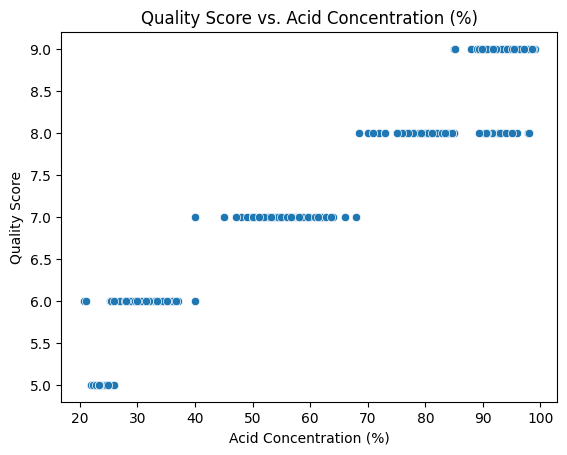

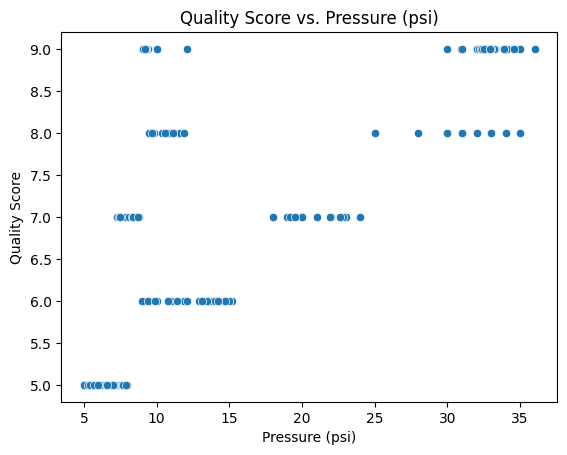

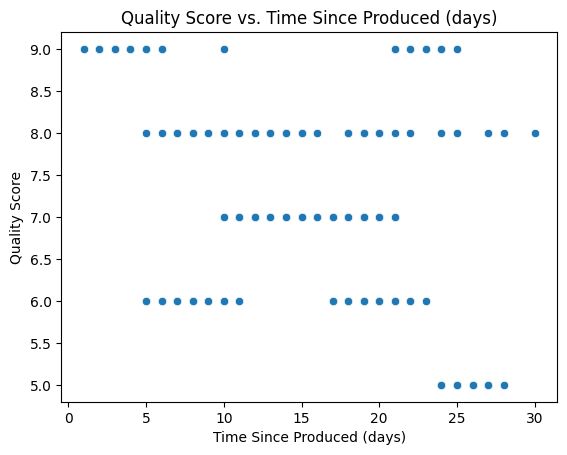

In [ ]:
# Create a scatterplot of quality score vs. each numerical column
for col in num_cols:
    sns.scatterplot(x=col, y='Quality Score', data=df.toPandas())
    plt.title(f'Quality Score vs. {col}')
    plt.show()

Seeing all these analysis, especially the correlation matrix, it is Clear that the features of the Dataset, namely ['Acid Concentration (%)', 'Pressure
(psi)', 'Type of Acid'] are the most affect features when it comes quality score, lets set up a regression model and test on set values.

0 - Hydrochloric Acid

1 - Nitric Acid

2 - Phosphoric Acid

3 - Sulfuric Acid

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Create a vector assembler to combine features
assembler = VectorAssembler(
inputCols=["Acid Concentration (%)", "Pressure (psi)", "Type of Acid"],
outputCol="features")

In [ ]:
# Use the vector assembler to transform the dataset
assembled = assembler.transform(df)

In [ ]:
# Split the dataset into training and test sets
train_data, test_data = assembled.randomSplit([0.7, 0.3], seed=123)

In [ ]:
# Create a linear regression model and fit it to the training data
lr = LinearRegression(featuresCol="features", labelCol="Quality Score")
model = lr.fit(train_data)

In [ ]:
# Evaluate the model on the test data
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Quality Score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.317281


In [ ]:
from pyspark.sql.types import *
# Define the schema for the test data
schema = StructType([
StructField("Acid Concentration (%)", DoubleType(), True),
StructField("Pressure (psi)", DoubleType(), True),
StructField("Type of Acid", IntegerType(), True)
])

In [ ]:
# Create a new DataFrame with the test data
data = [(90.0, 14.0, 1)]
test_df = spark.createDataFrame(data, schema)

In [ ]:
# assemble the features into a single vector column
assembler = VectorAssembler(inputCols=['Acid Concentration (%)', 'Pressure (psi)', 'Type of Acid'], outputCol='features')
test_assembled = assembler.transform(test_df)

In [ ]:
# make predictions using the trained model
predictions = model.transform(test_assembled)

In [ ]:
# show the predictions
predictions.select('Acid Concentration (%)', 'Pressure (psi)', 'Type of Acid', 'prediction').show()

+----------------------+--------------+------------+-----------------+
|Acid Concentration (%)|Pressure (psi)|Type of Acid|       prediction|
+----------------------+--------------+------------+-----------------+
|                  90.0|          14.0|           1|8.353019980281793|
+----------------------+--------------+------------+-----------------+

